<a href="https://colab.research.google.com/github/taninao1122/machine_learning/blob/master/tf2_train_mobile_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基本設定と定義

In [ ]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tf-nightly

In [ ]:
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.optimizers import SGD
# import os,glob
# import numpy as np
# import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory


import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# used_extend = True
# show_extend = True

# label_lists = ["have_camera","no_camera"]
# n_categories = len(label_lists)
# drive_path = "./drive/My Drive/camera_checker"

# saved_dir_name = drive_path + "/model_extends_all"
# save_model_path = saved_dir_name + "/model" 

In [ ]:
drive_path = "./drive/My Drive/camera_checker"
train_dir = os.path.join(drive_path + "/train")
val_dir =  os.path.join(drive_path + "/val")

# train事前準備

In [ ]:
BATCH_SIZE = 32
IMG_SIZE =224

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE,IMG_SIZE))

validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(IMG_SIZE,IMG_SIZE))


# ラベルの表示

In [ ]:
class_names = train_dataset.class_names
print(class_names)

In [ ]:
n_categories = len(class_names)
print(n_categories)

['have_camera', 'no_camera']


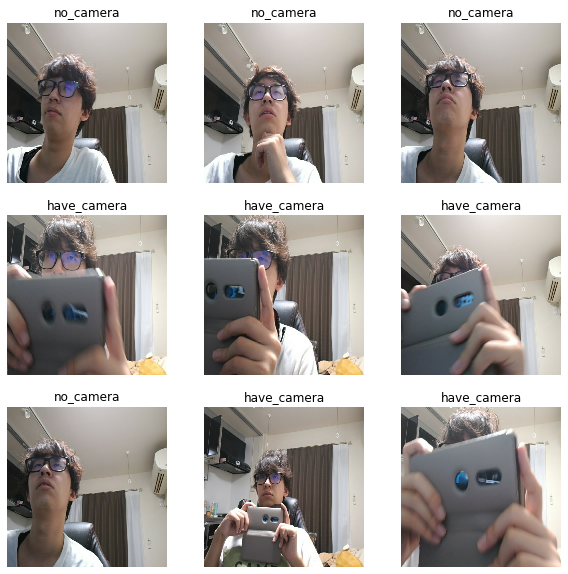

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# パフォーマンスのためのデータセット構成
- トレーニングステップの前処理とモデル実行をオーバーラップ
- 実行中はステップの一つ先を読み取る

- データが生成される時間とデータが消費される時間を分離するために使用

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
print(train_dataset)

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


# データ拡張の指定

In [1]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(.2, .2),
])


<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


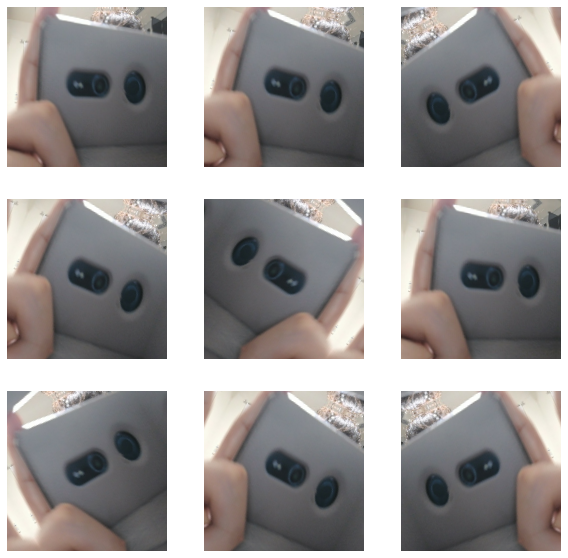

In [ ]:
print(train_dataset.take(1))
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model定義

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# 特徴抽出

In [ ]:
base_model.trainable = False
base_model.summary()

# 分類ヘッドの追加

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
if n_categories == 2:
    crossentropy = 'binary_crossentropy'
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
else:
    crossentropy = 'categorical_crossentropy'
    prediction_layer = tf.keras.layers.Dense(n_categories, activation = 'softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(crossentropy)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = resize_and_rescale(inputs)
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

## モデルの学習

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

1.2Kのトレーニング可能なパラメータがある。
これらはtf.Variableオブジェクトである重みとバイアスに分けられる

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 62s 410ms/step - loss: 0.7704 - accuracy: 0.5312


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.78
initial accuracy: 0.52


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
32/32 [==============================] - 199s 6s/step - loss: 0.7501 - accuracy: 0.5589 - val_loss: 0.7222 - val_accuracy: 0.6450
Epoch 2/10
32/32 [==============================] - 23s 683ms/step - loss: 0.6781 - accuracy: 0.6996 - val_loss: 0.6626 - val_accuracy: 0.7450
Epoch 3/10
32/32 [==============================] - 23s 679ms/step - loss: 0.6317 - accuracy: 0.7834 - val_loss: 0.6300 - val_accuracy: 0.8450
Epoch 4/10
32/32 [==============================] - 23s 681ms/step - loss: 0.6079 - accuracy: 0.8693 - val_loss: 0.6071 - val_accuracy: 0.9450
Epoch 5/10
32/32 [==============================] - 22s 663ms/step - loss: 0.5920 - accuracy: 0.9012 - val_loss: 0.5898 - val_accuracy: 0.9800
Epoch 6/10
32/32 [==============================] - 22s 676ms/step - loss: 0.5813 - accuracy: 0.9271 - val_loss: 0.5760 - val_accuracy: 0.9900
Epoch 7/10
32/32 [==============================] - 22s 666ms/step - loss: 0.5684 - accuracy: 0.9451 - val_loss: 0.5661 - val_accuracy: 0.9900
E

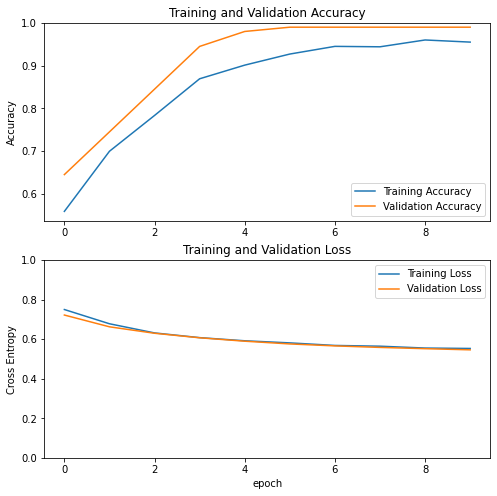

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()